## Bank Loan Prediction

### Synopsis:
    1) Data cleanup activities for Banking Dataset 
    2) Predict whether a person will get loan approval or not
    3) Quality metrics of the prediction using F1-score
    
### Data Set Used: 
    https://www.kaggle.com/rikdifos/credit-card-approval-prediction
    

### Import  the required Python libraries & packages¶
Now, let us begin by importing the necessary packages for our project

In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

### Import and analyze dataset

    1) Look at how the data looks
    2) Get the size of the datasets (rows & cols)
    3) Merge the datasets by ID
    4) Update the status feature

In [2]:
loan_data = pd.read_csv('cc_data.csv')
loan_data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
loan_data.shape

(438557, 18)

In [4]:
loan_data_status = pd.read_csv('cc_status.csv')

In [5]:
loan_data_status.shape

(1048575, 3)

In [6]:
begin_month=pd.DataFrame(loan_data_status.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(loan_data,loan_data_status,how="left",on="ID") 

In [7]:
loan_data_status['dep_value'] = None
loan_data_status['dep_value'][loan_data_status['STATUS'] =='2']='Yes' 
loan_data_status['dep_value'][loan_data_status['STATUS'] =='3']='Yes' 
loan_data_status['dep_value'][loan_data_status['STATUS'] =='4']='Yes' 
loan_data_status['dep_value'][loan_data_status['STATUS'] =='5']='Yes' 

In [8]:
cpunt=loan_data_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)


No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

In [9]:
loan_data_final = new_data

In [10]:
loan_data_final.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE',
       'STATUS', 'dep_value', 'target'],
      dtype='object')

In [11]:
loan_data_final['target'].value_counts()

0    757150
1     20565
Name: target, dtype: int64

### Data Cleaning

#### Feature Selection - Selection of required/ necessary features to be used in the model

In [12]:
loan_data_final.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE',
       'STATUS', 'dep_value', 'target'],
      dtype='object')

In [13]:
features = [ 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','OCCUPATION_TYPE', 'target']
loan_pred_ds = loan_data_final[features]

In [14]:
loan_pred_ds['target'].value_counts()

0    757150
1     20565
Name: target, dtype: int64

#### Categorical columns needs to converted to Numeric columns for Classification problems

In [15]:
# newpred = model.predict([[1, 1, 1, 180000, 0, 0, 1, 0 , 1]])

def conversion_numerics(row):
    if row['CODE_GENDER'] == 'F' :
        return 0
    if row['CODE_GENDER'] == 'M' :
        return 1
    if row['FLAG_OWN_CAR'] == 'Y' :
        return 0
    if row['FLAG_OWN_CAR'] == 'N' :
        return 1
    if row['FLAG_OWN_REALTY'] == 'Y' :
        return 0
    if row['FLAG_OWN_REALTY'] == 'N' :
        return 1
    if row['NAME_INCOME_TYPE'] == 'Working' :
        return 0
    if row['NAME_INCOME_TYPE'] == 'Commercial associate' :
        return 0
    if row['NAME_INCOME_TYPE'] == 'Pensioner' :
        return 0
    if row['NAME_INCOME_TYPE'] == 'State servant' :
        return 0
    if row['NAME_INCOME_TYPE'] == 'Student' :
        return 1
    if row['NAME_EDUCATION_TYPE'] == 'Secondary / secondary special' :
        return 0
    if row['NAME_EDUCATION_TYPE'] == 'Higher education' :
        return 1
    if row['NAME_EDUCATION_TYPE'] == 'Incomplete higher' :
        return 0
    if row['NAME_EDUCATION_TYPE'] == 'Lower secondary' :
        return 0
    if row['NAME_EDUCATION_TYPE'] == 'Academic degree' :
        return 1
    if row['NAME_FAMILY_STATUS'] == 'Married' :
        return 0
    if row['NAME_FAMILY_STATUS'] == 'Single / not married' :
        return 1
    if row['NAME_FAMILY_STATUS'] == 'Civil marriage' :
        return 0
    if row['NAME_FAMILY_STATUS'] == 'Separated' :
        return 1
    if row['NAME_FAMILY_STATUS'] == 'Widow' :
        return 1
    if row['NAME_HOUSING_TYPE'] == 'House / apartment' :
        return 0
    if row['NAME_HOUSING_TYPE'] == 'With parents' :
        return 1
    if row['NAME_HOUSING_TYPE'] == 'Municipal apartment' :
        return 1
    if row['NAME_HOUSING_TYPE'] == 'Rented apartment' :
        return 1
    if row['NAME_HOUSING_TYPE'] == 'Office apartment' :
        return 1
    if row['NAME_HOUSING_TYPE'] == 'Co-op apartment' :
        return 1
    if row['OCCUPATION_TYPE'] == 'Laborers' :
        return 1
    if row['OCCUPATION_TYPE'] == 'Sales staff' :
        return 1
    if row['OCCUPATION_TYPE'] == 'Core staff' :
        return 1
    if row['OCCUPATION_TYPE'] == 'Managers' :
        return 0
    if row['OCCUPATION_TYPE'] == 'Drivers' :
        return 1
    if row['OCCUPATION_TYPE'] == 'High skill tech staff' :
        return 0
    if row['OCCUPATION_TYPE'] == 'Accountants' :
        return 0
    if row['OCCUPATION_TYPE'] == 'Medicine staff ' :
        return 0
    if row['OCCUPATION_TYPE'] == 'Cooking staff' :
        return 1
    if row['OCCUPATION_TYPE'] == 'Security staff' :
        return 1
    if row['OCCUPATION_TYPE'] == 'Cleaning staff' :
        return 1
    if row['OCCUPATION_TYPE'] == 'Private service staff' :
        return 1
    if row['OCCUPATION_TYPE'] == 'Low-skill Laborers' :
        return 1
    if row['OCCUPATION_TYPE'] == 'Secretaries' :
        return 0
    if row['OCCUPATION_TYPE'] == 'Waiters/barmen staff' :
        return 1
    if row['OCCUPATION_TYPE'] == 'HR staff' :
        return 0
    if row['OCCUPATION_TYPE'] == 'IT staff' :
        return 0
    if row['OCCUPATION_TYPE'] == 'Realty agents' :
        return 0

In [16]:
loan_pred_ds['CODE_GENDER'] = loan_pred_ds.apply(lambda row: conversion_numerics(row), axis=1)
loan_pred_ds['FLAG_OWN_CAR'] = loan_pred_ds.apply(lambda row: conversion_numerics(row), axis=1)
loan_pred_ds['FLAG_OWN_REALTY'] = loan_pred_ds.apply(lambda row: conversion_numerics(row), axis=1)
loan_pred_ds['NAME_INCOME_TYPE'] = loan_pred_ds.apply(lambda row: conversion_numerics(row), axis=1)
loan_pred_ds['NAME_EDUCATION_TYPE'] = loan_pred_ds.apply(lambda row: conversion_numerics(row), axis=1)
loan_pred_ds['NAME_FAMILY_STATUS'] = loan_pred_ds.apply(lambda row: conversion_numerics(row), axis=1)
loan_pred_ds['NAME_HOUSING_TYPE'] = loan_pred_ds.apply(lambda row: conversion_numerics(row), axis=1)
loan_pred_ds['OCCUPATION_TYPE'] = loan_pred_ds.apply(lambda row: conversion_numerics(row), axis=1)

In [17]:
loan_pred_ds.head(5)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,target
0,1,0,0,427500.0,0,1,0,1,NaN,0
1,1,0,0,427500.0,0,1,0,1,NaN,0
2,1,0,0,427500.0,0,1,0,1,NaN,0
3,1,0,0,427500.0,0,1,0,1,NaN,0
4,1,0,0,427500.0,0,1,0,1,NaN,0


In [18]:
loan_pred_ds.shape

(777715, 10)

In [19]:
loan_pred_ds['target'].value_counts()

0    757150
1     20565
Name: target, dtype: int64

#### Update NaN/Null values in the Loan Dataframe 

In [20]:
loan_pred_ds.isnull().sum()

CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
OCCUPATION_TYPE        266739
target                      0
dtype: int64

In [21]:
loan_pred_ds['OCCUPATION_TYPE'] = loan_pred_ds['OCCUPATION_TYPE'].fillna(2)
loan_pred_ds.isnull().sum()

CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
OCCUPATION_TYPE        0
target                 0
dtype: int64

#### Convert all columns to INT datatype

In [22]:
loan_pred_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777715 entries, 0 to 777714
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          777715 non-null  int64  
 1   FLAG_OWN_CAR         777715 non-null  int64  
 2   FLAG_OWN_REALTY      777715 non-null  int64  
 3   AMT_INCOME_TOTAL     777715 non-null  float64
 4   NAME_INCOME_TYPE     777715 non-null  int64  
 5   NAME_EDUCATION_TYPE  777715 non-null  int64  
 6   NAME_FAMILY_STATUS   777715 non-null  int64  
 7   NAME_HOUSING_TYPE    777715 non-null  int64  
 8   OCCUPATION_TYPE      777715 non-null  float64
 9   target               777715 non-null  object 
dtypes: float64(2), int64(7), object(1)
memory usage: 65.3+ MB


In [23]:
cols = ['AMT_INCOME_TOTAL', 'OCCUPATION_TYPE', 'target']
loan_pred_ds[cols] = loan_pred_ds[cols].applymap(np.int64)

In [24]:
loan_pred_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777715 entries, 0 to 777714
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   CODE_GENDER          777715 non-null  int64
 1   FLAG_OWN_CAR         777715 non-null  int64
 2   FLAG_OWN_REALTY      777715 non-null  int64
 3   AMT_INCOME_TOTAL     777715 non-null  int64
 4   NAME_INCOME_TYPE     777715 non-null  int64
 5   NAME_EDUCATION_TYPE  777715 non-null  int64
 6   NAME_FAMILY_STATUS   777715 non-null  int64
 7   NAME_HOUSING_TYPE    777715 non-null  int64
 8   OCCUPATION_TYPE      777715 non-null  int64
 9   target               777715 non-null  int64
dtypes: int64(10)
memory usage: 65.3 MB


In [25]:
loan_pred_ds.rename(columns={'target':'Loan_Status'}, inplace=True)

#### Confusion Matrix plot function

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
final_df = loan_pred_ds

In [28]:
final_df.shape

(777715, 10)

In [29]:
final_df = final_df.drop_duplicates()

In [30]:
final_df.shape

(3310, 10)

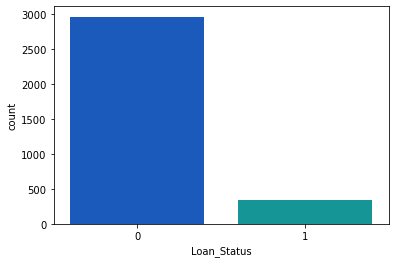

In [31]:
sns.countplot(final_df["Loan_Status"], palette = 'winter')

In [32]:
final_df.loc[final_df['Loan_Status'] == 1].head(5)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,Loan_Status
13631,0,1,1,238500,0,0,0,0,1,1
15869,0,0,1,315000,0,1,0,0,2,1
19130,0,1,0,157500,0,0,0,0,1,1
21075,0,1,0,112500,0,0,0,0,2,1
29188,0,0,1,135000,0,0,0,0,1,1


In [33]:
final_df['Loan_Status'].value_counts()

0    2965
1     345
Name: Loan_Status, dtype: int64

In [34]:
final_df.sort_values('AMT_INCOME_TOTAL')

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,Loan_Status
656761,0,1,1,27000,0,1,0,0,0,0
725010,0,1,0,27000,0,0,0,0,1,0
681881,0,0,0,29250,0,0,0,0,2,0
215879,1,1,0,30150,0,0,0,0,2,0
421798,0,0,1,31500,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
566373,1,0,0,1125000,0,1,0,0,0,0
453520,0,0,0,1125000,0,1,0,0,0,0
107670,1,0,1,1125000,0,0,0,1,0,0
15027,1,0,1,1350000,0,1,0,1,0,0


#### Save the cleaned dataset to be used in Web application

In [35]:
#final_df.to_csv('final_df.csv', index=False)

### Loan Prediction and Quality measurement

#### Define X and y for prediction and split using train_test_split function

#### Using SMOTE function due to dataset's unbalanced nature

In [36]:
y1 = final_df['Loan_Status']
X1 = final_df.drop(['Loan_Status'], axis = 1)
X_balance,Y_balance = SMOTE().fit_sample(X1,y1)
Y_balance.value_counts()

1    2965
0    2965
Name: Loan_Status, dtype: int64

In [37]:
X_balance,Y_balance = SMOTE().fit_sample(X1,y1)
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.25,
                                                    random_state = 10086)
Y_balance.value_counts()

1    2965
0    2965
Name: Loan_Status, dtype: int64

#### Random Forest Classifier 

In [38]:
%%time
model = RandomForestClassifier(max_depth = 20)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.2}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

print('F1-Score is {:.2}'.format(f1_score(y_test, y_predict, average='weighted')))


Accuracy Score is 0.82
     0    1
0  574  168
1   98  643
F1-Score is 0.82
CPU times: user 320 ms, sys: 7.89 ms, total: 328 ms
Wall time: 327 ms


[[0.77358491 0.22641509]
 [0.13225371 0.86774629]]


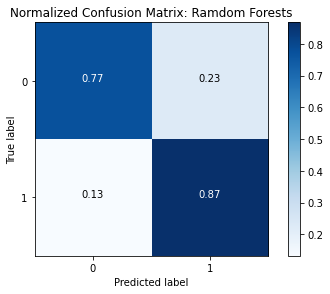

In [39]:
confusion_matrix_plot = plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=[0,1], normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')


In [40]:
matrix = classification_report(y_test, y_predict, labels=[0,1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.77      0.81       742
           1       0.79      0.87      0.83       741

    accuracy                           0.82      1483
   macro avg       0.82      0.82      0.82      1483
weighted avg       0.82      0.82      0.82      1483



In [41]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
AMT_INCOME_TOTAL,0.639
OCCUPATION_TYPE,0.069
NAME_EDUCATION_TYPE,0.067
NAME_HOUSING_TYPE,0.064
NAME_FAMILY_STATUS,0.048
CODE_GENDER,0.042
FLAG_OWN_REALTY,0.037
FLAG_OWN_CAR,0.034
NAME_INCOME_TYPE,0.001


#### Test the prediction with values

In [42]:
newpred = model.predict([[1, 1, 0, 180000, 0, 0, 1, 0 , 1]])
newpred

array([1])

In [43]:
newpred = model.predict([[0, 1, 1, 315000, 0, 0, 0, 0 , 1]])
newpred

array([0])

In [44]:
newpred = model.predict([[1, 1, 0, 180000, 0, 0, 1, 0 , 1]])
newpred

array([1])

In [45]:
newpred = model.predict([[1, 1, 0, 180000, 0, 0, 1, 0 , 1]])
newpred

array([1])

In [46]:
newpred = model.predict([[1, 1, 1, 180000, 0, 0, 1, 0 , 1]])
newpred

array([1])